In [3]:
%matplotlib inline
from math import log
from numpy import average, array, clip, dstack, histogram
from skimage.color import rgb2gray
from skimage.io import imread, imsave, imshow
from skimage.util import img_as_ubyte, img_as_float


def downgrade(img, levels_n: int = 256):
    '''Уменьшение кол-ва уровней яркости изображения'''
    downgraded_img = img // (256 // levels_n)
    return downgraded_img


def restore(img, levels_n: int = 256):
    '''восстановление изображения для просмотра'''
    restored_img = img * (256 // levels_n)
    return restored_img


img_name = ('C:\cs173\\img.png')
img = imread(img_name)
img_gray = rgb2gray(img)
img_one_channel = img_as_ubyte(img_gray)
levels_n = 2
downgraded_img = downgrade(img_one_channel, levels_n)
restored_img = restore(downgraded_img, levels_n)
imsave(f'restored_img_{levels_n}_levels.png', restored_img)

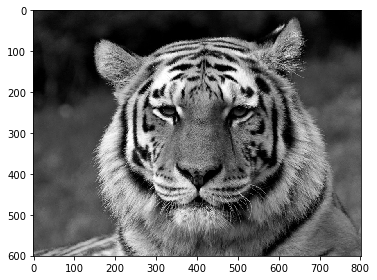

In [4]:
imshow(img_gray)

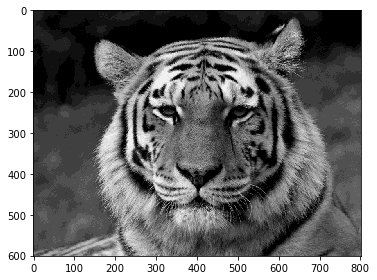

In [5]:
#  На 16 уровнях яркости изображение выглядит ещё приемлемо

output_img = imread('C:\cs173\lab1\\restored_img_16_levels.png')
imshow(output_img)

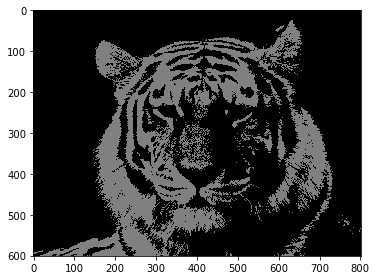

In [6]:
#  Так выглядит на 2 уровнях:

output_img = imread('C:\cs173\lab1\\restored_img_2_levels.png')
imshow(output_img)

In [7]:
def decimate(channel):
    ch = []
    for x in range(channel.shape[0]):
        if x % 2 != 0:
            ch.append([])
        for y in range(channel.shape[1]):
            if x % 2 != 0 and y % 2 != 0:
                avg = average(channel[x-1: x, y-1: y])
                ch[x // 2].append(avg)
    ch = array(ch)
    return ch


def rgb_to_yuv(img) -> tuple:
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]
    y_channel = 0.299 * r + 0.587 * g + 0.114 * b
    u_channel = -0.147 * r - 0.289 * g + 0.436 * b
    v_channel = 0.615 * r - 0.515 * g - 0.100 * b
    u = decimate(u_channel)
    v = decimate(v_channel)
    return (y_channel, u, v)


def yuv_to_rgb(yuv_img: tuple):
    y_channel = yuv_img[0]
    u = yuv_img[1]
    v = yuv_img[2]
    r = y_channel.copy()
    g = y_channel.copy()
    b = y_channel.copy()
    for x in range(y_channel.shape[0]):
        for y in range(y_channel.shape[1]):
            x_for_uv = x - 1 if x > len(u) // 2 else x
            y_for_uv = y - 1 if y > len(u[0]) // 2 else y
            u_channel = u[x_for_uv // 2, y_for_uv // 2]
            v_channel = v[x_for_uv // 2, y_for_uv // 2]
            r[x, y] = clip((y_channel[x, y] + 1.14 * v_channel), 0, 1)
            g[x, y] = clip((y_channel[x, y] - 0.395 * u_channel -
                           0.581 * v_channel), 0, 1)
            b[x, y] = clip((y_channel[x, y] + 2.032 * u_channel), 0, 1)

    rgb_img = dstack((r, g, b))
    rgb_img = img_as_ubyte(rgb_img)
    return rgb_img


if __name__ == '__main__':
    img = imread('C:\cs173\\img.png')
    img = img_as_float(img)
    yuv_img = rgb_to_yuv(img)
    rgb_img = yuv_to_rgb(yuv_img)

KeyboardInterrupt: 

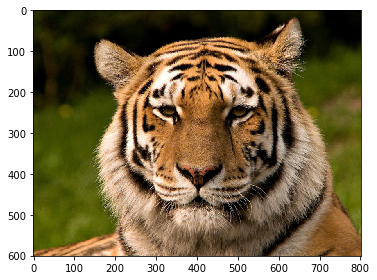

In [6]:
imshow(img)
# Исходное изображение

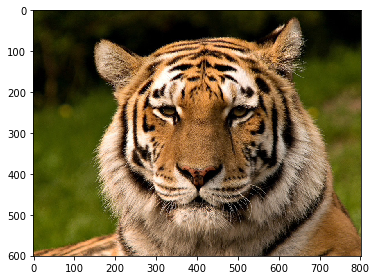

In [7]:
imshow(rgb_img)
#  После декодирования

In [25]:
def count_entropy_one_channel(img) -> float:
    img = img_as_ubyte(img)
    entropy = 0
    size = img.shape[0] * img.shape[1]
    h, bins = histogram(img, bins=range(256))
    values = list(h)
    for v in values:
        if v:
            entropy += (v / size) * log((v/size), 2)
    entropy *= -1 
    return entropy


def count_rgb_entropy(img) -> float:
    '''Кол-во информации по каждому каналу отдельно '''
    img = img_as_ubyte(img)
    size = img.shape[0] * img.shape[1]
    entropy = []
    for ch in range(3):
        ch_entropy = 0
        h, bins = histogram(img[:, :, ch], bins=range(256))
        values = list(h)
        for v in values:
            if v:
                ch_entropy += (v / size) * log((v/size), 2)
        ch_entropy *= -1
        entropy.append(ch_entropy)
    return entropy


def count_standard_deviation(img1, img2) -> float:
    img1 = img1.astype('int32')
    img2 = img2.astype('int32')
   
    res = img1 - img2
    res = res * res
    res = sum(sum(res))
    res = res / (img1.shape[0] * img1.shape[1])
    return res

In [26]:
img1 = imread('C:\cs173\\img.png')
img1 = rgb2gray(img1)
img1 = img_as_ubyte(img1)
size = img1.shape[0] * img1.shape[1]
img2 = imread('C:\cs173\lab1\\restored_img_16_levels.png')
img2 = rgb2gray(img2)
print('Уменьшение уровней яркости:')
print('Энтропия исходного изображения:', count_entropy_one_channel(img1), 'бит')
print('Энтропия после уменьшения уровней яркости (16 уровней) и декодирования:', count_entropy_one_channel(img2), 'бит')
print('Среднеквадратичная ошибка:')
print(count_standard_deviation(img1, img2), '\n')

img3 = imread('C:\cs173\\lab1\\img.png')
img4 = imread('C:\cs173\\lab1\\rgb_img.png')
print('Из RGB в YUV:')
print('Энтропия исходного изображения:', count_rgb_entropy(img3), 'бит')
print('Энтропия после декодирования из YUV в RGB:', count_rgb_entropy(img4), 'бит')
print('Среднеквадратичная ошибка:')
print(count_standard_deviation(img3[:, :, 0], img4[:, :, 0]), count_standard_deviation(img3[:, :, 1], img4[:, :, 1]), count_standard_deviation(img3[:, :, 2], img4[:, :, 2]))

Уменьшение уровней яркости:
Энтропия исходного изображения: 7.676461175621061 бит
Энтропия после уменьшения уровней яркости (16 уровней) и декодирования: 3.7096308000171496 бит
Среднеквадратичная ошибка:
73.14425603602818 

Из RGB в YUV:
Энтропия исходного изображения: [7.863871774423019, 7.627986947364539, 6.688709729507241] бит
Энтропия после декодирования из YUV в RGB: [7.853440376641024, 7.627815425056957, 6.702082177167373] бит
Среднеквадратичная ошибка:
15.312045467292341 3.0735499095348784 49.26594045296956


Вывод: <br>
При переводе из RGB в YUV и обратно потери информации незначительны (возникают из-за децимации). <br>
При уменьшении уровней яркости энтропия уменьшается (т.к. пиксели могут принимать меньше различных значений). Однако на 16 уровнях яркости изображение выглядит ещё приемлемо, а весит гораздо меньше в закодированном формате.